# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../common_settings.py

# Load data

In [2]:
raw_ad0 = sc.read_10x_h5('reitermaier21/GSE156972_raw_gene_bc_matrices_h5.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
raw_ad0.var_names_make_unique()

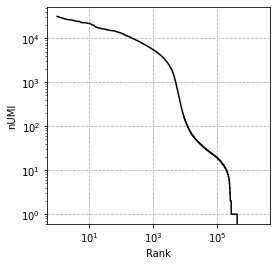

In [18]:
sk.plot_metric_by_rank(raw_ad0, swap_axis=True);

In [6]:
all_annot = pd.read_csv('reitermaier21/GSE156972_CellAnnotation_AllCells.tsv.gz', sep='\t', index_col=0)

In [23]:
all_annot.head(2)

,Userdefined
Barcode,
AAACCTGGTCGAGTTT-1,T cells
AAACCTGTCCTTGCCA-1,T cells


In [7]:
t_annot = pd.read_csv('reitermaier21/GSE156972_CellAnnotation_Tcells.tsv.gz', sep='\t', index_col=0)

In [24]:
t_annot.head(2)

,Probability,T cell subset
Barcode,,
AAACCTGAGAAGCCCA-2,0.462487,DPos
AAACCTGCAATAGCGG-2,0.566253,DPos


In [14]:
raw_ad1 = raw_ad0[raw_ad0.obs_names.isin(all_annot.index)].copy()

In [15]:
raw_ad1

AnnData object with n_obs × n_vars = 5489 × 33694
    var: 'gene_ids'

In [21]:
np.all(raw_ad1.obs_names == all_annot.index)

True

In [22]:
raw_ad1.obs['broad_annot'] = all_annot.Userdefined.astype('category')

In [25]:
raw_ad1.obs.loc[raw_ad1.obs_names.isin(t_annot.index), 't_annot'] = t_annot['T cell subset'].astype('category')
raw_ad1.obs.loc[raw_ad1.obs_names.isin(t_annot.index), 't_annot_prob'] = t_annot['Probability'].values

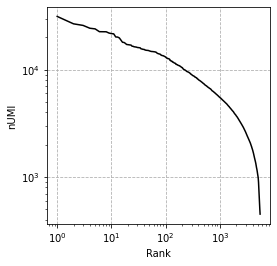

In [19]:
sk.plot_metric_by_rank(raw_ad1, swap_axis=True);

# Process

In [16]:
sk.calculate_qc(raw_ad1)

... storing 't_annot' as categorical


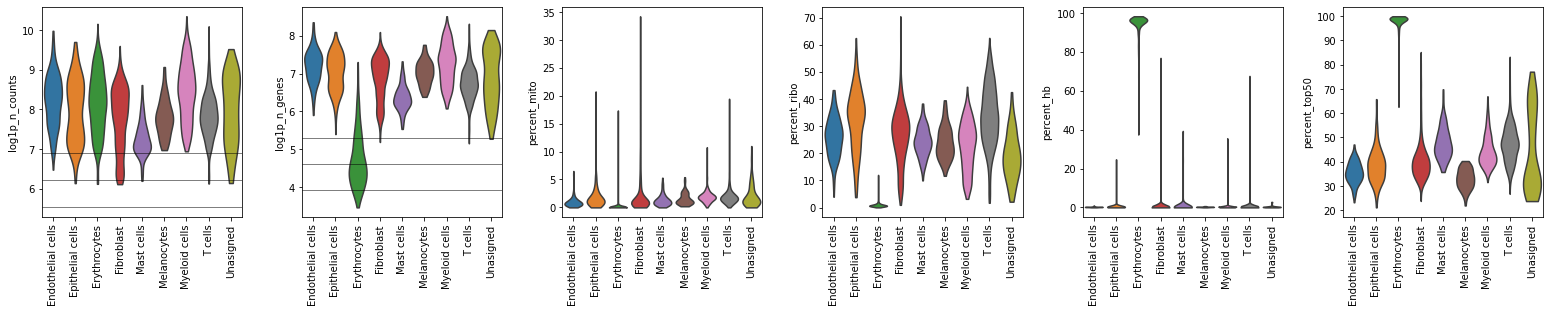

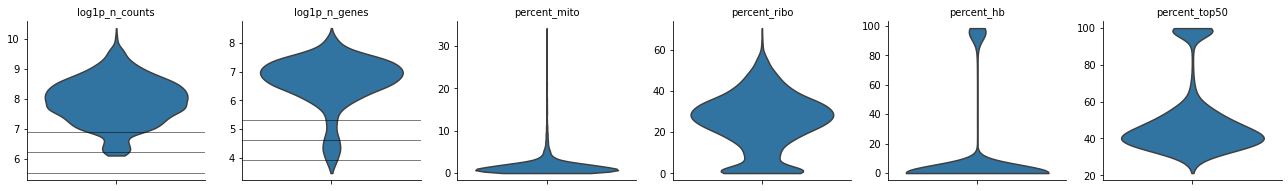

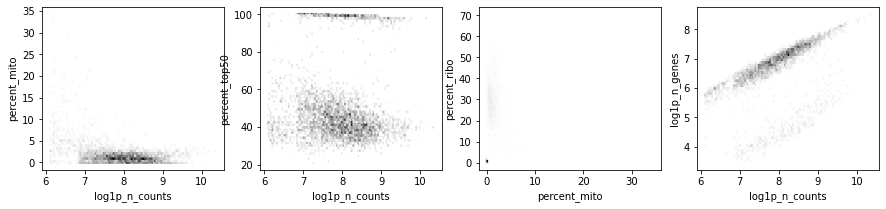

In [26]:
sk.plot_qc(raw_ad1, groupby='broad_annot')

In [27]:
ad1 = sk.simple_default_pipeline(
    raw_ad1,
    post_filter_only=True,
    pca_kw={'remove_genes': ['mito', 'ribo']},
)

In [28]:
ad1

AnnData object with n_obs × n_vars = 5489 × 3707
    obs: 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'broad_annot', 't_annot', 't_annot_prob'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'hvg_full'
    uns: 'broad_annot_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

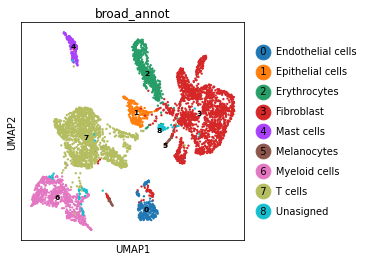

In [30]:
sk.plot_embedding(ad1, groupby='broad_annot');

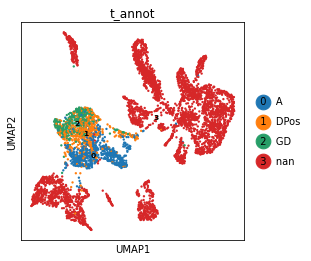

In [31]:
sk.plot_embedding(ad1, groupby='t_annot');

In [33]:
sk.cross_table(ad1, 'broad_annot', 't_annot')

t_annot,A,DPos,GD,nan
broad_annot,,,,
Endothelial cells,0,0,0,229
Epithelial cells,0,0,0,234
Erythrocytes,0,0,0,627
Fibroblast,0,0,0,1767
Mast cells,0,0,0,145
Melanocytes,0,0,0,69
Myeloid cells,0,0,0,683
T cells,713,557,369,0
Unasigned,0,0,0,96


In [34]:
ad1.obs['annot0'] = ad1.obs.broad_annot.astype(str)
ad1.obs.loc[ad1.obs.broad_annot=='T cells', 'annot0'] = ad1.obs.loc[ad1.obs.broad_annot=='T cells', 't_annot'].astype(str)
ad1.obs['annot0'] = ad1.obs['annot0'].astype('category')

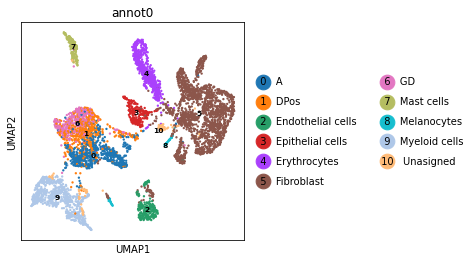

In [35]:
sk.plot_embedding(ad1, groupby='annot0');

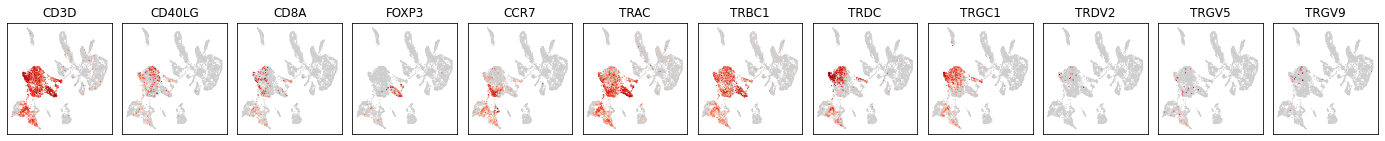

In [54]:
sk.plot_genes(ad1, genes=['CD3D', 'CD40LG', 'CD8A', 'FOXP3', 'CCR7', 'TRAC', 'TRBC1', 'TRDC', 'TRGC1', 'TRDV2', 'TRGV5', 'TRGV9'], size=5)

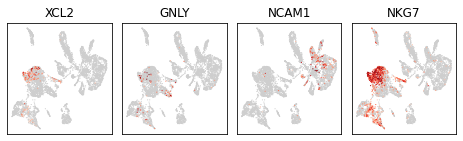

In [5]:
sk.plot_genes(ad1, genes=['XCL2', 'GNLY', 'NCAM1', 'NKG7'], size=5)

In [42]:
sk.LR_predict(ad1, '../20200804_fig1/lr_model/pooled_fetal_lognorm_LR.pkl', use_rep='raw', key_added='fsk_annot')

20228 features used for prediction


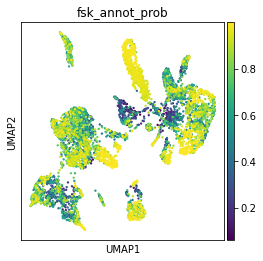

In [49]:
sk.set_figsize((4, 4))
sc.pl.umap(ad1, color='fsk_annot_prob')

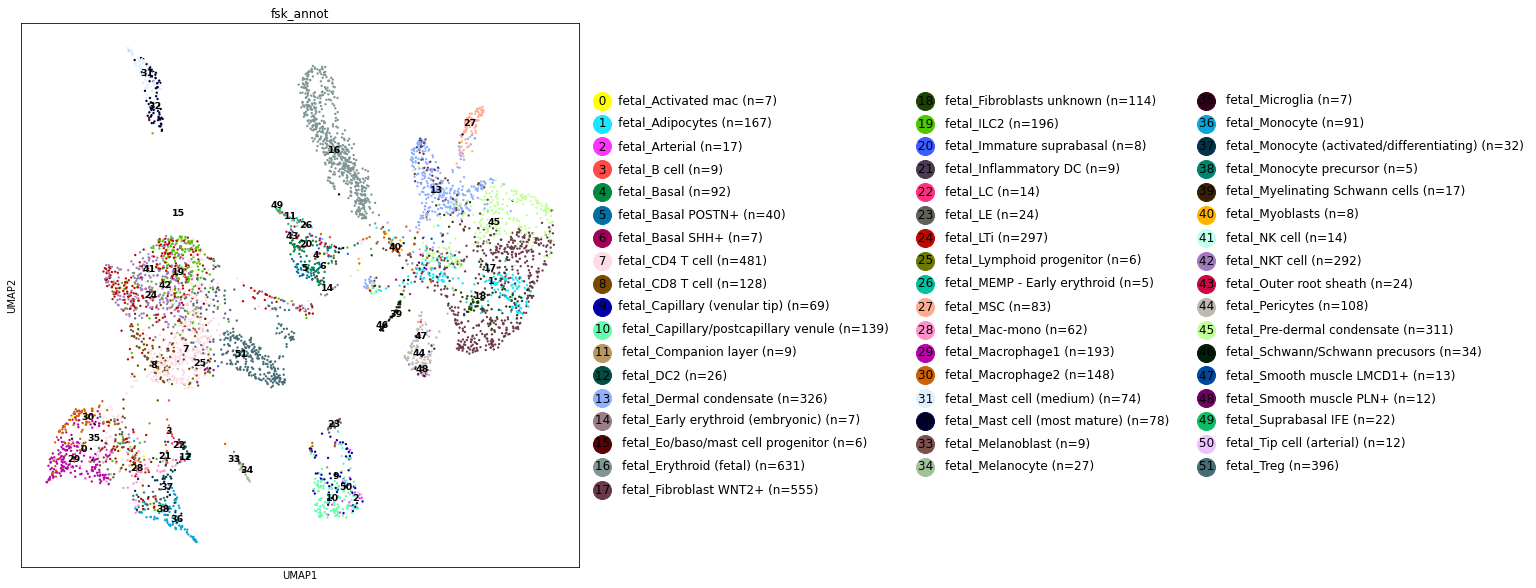

In [50]:
sk.plot_embedding(ad1, groupby='fsk_annot', annot='full', figsize=(10, 10), legend_fontsize=11, min_group_size=5);

In [51]:
sk.clear_colors(ad1)
ad1.write('reitermaier21.reprocessed.h5ad', compression='lzf')

In [2]:
ad1 = sc.read('reitermaier21.reprocessed.h5ad')